In [47]:
import numpy as np
from scipy.ndimage.filters import generic_filter as gf
from PIL import Image
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage
import scipy.stats.mstats as ms
import scipy.ndimage.morphology as morph
Image.MAX_IMAGE_PIXELS = None
import math

In [2]:
def create_circular_mask(radius):
    kernel = np.zeros((2*radius+1, 2*radius+1))
    y,x = np.ogrid[-radius:radius+1, -radius:radius+1]
    mask = x**2 + y**2 <= radius**2
    mask[radius][radius] = 0
    kernel[mask] = 1
    return kernel

In [3]:
def create_conic_mask(radius, direction):
    kernel = np.zeros((2*radius+1, 2*radius+1))
    y,x = np.ogrid[-radius:radius+1, -radius:radius+1]
    
    if direction == 0: #topright
        mask = (x > y) & (x < abs(y)) & (x**2 + y**2 <= radius**2) & (x > 0)
    elif direction == 1: #righttop
        mask = (x > abs(y)) & (x**2 + y**2 <= radius**2) & (y < 0)
    elif direction == 2: #rightbottom
        mask = (x > abs(y)) & (x**2 + y**2 <= radius**2) & (y > 0)
    elif direction == 3: #bottomright
        mask = (abs(x) < y) & (x**2 + y**2 <= radius**2) & (x > 0)
    elif direction == 4: #bottomleft
        mask = (abs(x) < y) & (x**2 + y**2 <= radius**2) & (x < 0)
    elif direction == 5: #leftbottom
        mask = (abs(x) > abs(y)) & (x < abs(y)) & (x**2 + y**2 <= radius**2) & (y > 0)
    elif direction == 6: #lefttop
        mask = (abs(x) > abs(y)) & (x < abs(y)) & (x**2 + y**2 <= radius**2) & (y < 0)
    elif direction == 7: #topleft
        mask = (x > y) & (x < abs(y)) & (x**2 + y**2 <= radius**2) & (x < 0)
    kernel[mask] = 1
    return kernel

def conicMean(arr, maskRadius, threshold):
    masks = []
    for i in range(0, 8):
        masks.append(create_conic_mask(maskRadius, i))
    newArr = arr.copy()
    amountOfThresholds = 0
    for i in range(len(arr)):
        for j in range(len(arr[i])):
            topRight = meanFromMask(arr, (i, j), masks[0])
            rightTop = meanFromMask(arr, (i, j), masks[1])
            rightBottom = meanFromMask(arr, (i, j), masks[2])
            bottomRight = meanFromMask(arr, (i, j), masks[3])
            bottomLeft = meanFromMask(arr, (i, j), masks[4])
            leftBottom = meanFromMask(arr, (i, j), masks[5])
            leftTop = meanFromMask(arr, (i, j), masks[6])
            topLeft = meanFromMask(arr, (i, j), masks[7])
            if topRight < threshold:
                if bottomLeft < threshold:
                    amountOfThresholds += 1
                    newArr[i][j] = 0.95 * (topRight if topRight < bottomLeft else bottomLeft)
            
            elif rightTop < threshold:
                if leftBottom < threshold:
                    amountOfThresholds += 1
                    newArr[i][j] = 0.95 * (leftBottom if leftBottom < rightTop else rightTop)
            
            elif rightBottom < threshold:
                if leftTop < threshold:
                    amountOfThresholds += 1
                    newArr[i][j] = 0.95 * (rightBottom if rightBottom < leftTop else leftTop)
            
            elif bottomRight < threshold:
                if topLeft < threshold:
                    amountOfThresholds += 1
                    newArr[i][j] = 0.95 * (bottomRight if bottomRight < topLeft else topLeft)
            if newArr[i][j] > arr[i][j]:
                newArr[i][j] = arr[i][j]
    print(amountOfThresholds)        
    return newArr

def meanFromMask(arr, index, mask):
    elementAmount = 0
    row = index[0]
    col = index[1]
    
    halfMask = len(mask) // 2
    
    arrLenRow = len(arr)
    arrLenCol = len(arr[row])
    
    elementSum = 0
    for i in range(-halfMask , halfMask):
        for j in range(-halfMask , halfMask):
            if arrLenCol > col + j + 1 or col + j + 1 >= 0 or arrLenRow > row + i + 1 or row + i + 1 >= 0:
                if mask[i + halfMask][j + halfMask] == 1:
                    if row + i + 1 < arrLenRow:
                        if col + j + 1 < arrLenCol:
                            elementSum += arr[row + i][col + j]
                            elementAmount += 1
    return elementSum / elementAmount if elementAmount != 0 else 0.99

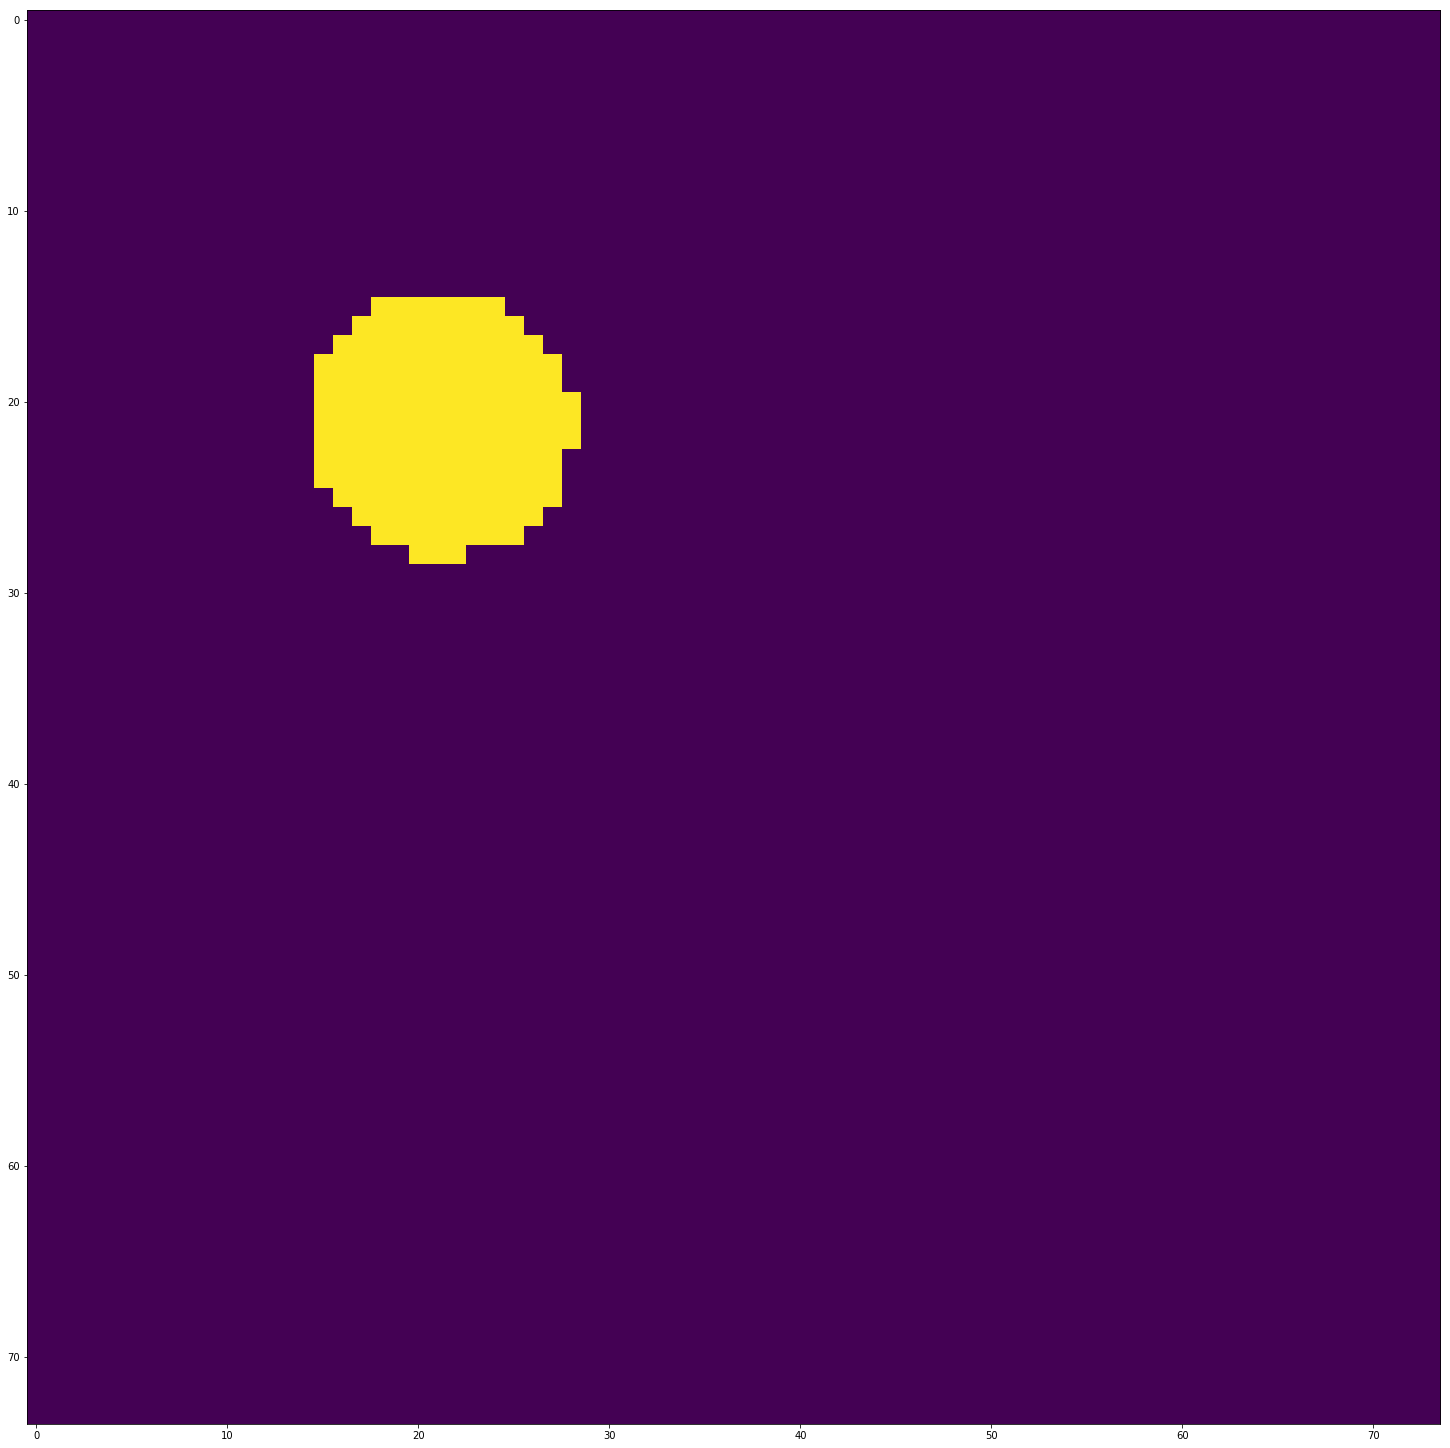

In [54]:
plt.figure(num=None, figsize=(28,26), facecolor='w', edgecolor='k')
plt.imshow(create_opposing_mask(7, 30, 0))

In [50]:
def create_opposing_mask(radius, distance, direction):
    #kernel = np.zeros(((distance + radius)*2, (distance + radius)*2))
    #y,x = np.ogrid[-radius:radius+1, -radius:radius+1]
    
    x = np.arange(0, (distance + radius)*2)
    y = np.arange(0, (distance + radius)*2)
    
    if direction == 0: #topright
        mask = (x[np.newaxis,:]-math.sqrt(distance**2/2))**2 + (y[:,np.newaxis]-math.sqrt(distance**2/2))**2 < radius**2
    elif direction == 1: #righttop
        mask = (x > abs(y)) & (x**2 + y**2 <= radius**2) & (y < 0)
    elif direction == 2: #rightbottom
        mask = (x > abs(y)) & (x**2 + y**2 <= radius**2) & (y > 0)
    elif direction == 3: #bottomright
        mask = (abs(x) < y) & (x**2 + y**2 <= radius**2) & (x > 0)
    elif direction == 4: #bottomleft
        mask = (abs(x) < y) & (x**2 + y**2 <= radius**2) & (x < 0)
    elif direction == 5: #leftbottom
        mask = (abs(x) > abs(y)) & (x < abs(y)) & (x**2 + y**2 <= radius**2) & (y > 0)
    elif direction == 6: #lefttop
        mask = (abs(x) > abs(y)) & (x < abs(y)) & (x**2 + y**2 <= radius**2) & (y < 0)
    elif direction == 7: #topleft
        mask = (x > y) & (x < abs(y)) & (x**2 + y**2 <= radius**2) & (x < 0)
    #kernel[mask] = 1
    return mask

'''
def create_opposing_mask(radius, distance, direction):
    kernel = np.zeros((2*radius+1, 2*radius+1))
    y,x = np.ogrid[-radius:radius+1, -radius:radius+1]
    
    if direction == 0: #topright
        mask = (x > y) & (x < abs(y)) & (x**2 + y**2 <= radius**2) & (x > 0)
    elif direction == 1: #righttop
        mask = (x > abs(y)) & (x**2 + y**2 <= radius**2) & (y < 0)
    elif direction == 2: #rightbottom
        mask = (x > abs(y)) & (x**2 + y**2 <= radius**2) & (y > 0)
    elif direction == 3: #bottomright
        mask = (abs(x) < y) & (x**2 + y**2 <= radius**2) & (x > 0)
    elif direction == 4: #bottomleft
        mask = (abs(x) < y) & (x**2 + y**2 <= radius**2) & (x < 0)
    elif direction == 5: #leftbottom
        mask = (abs(x) > abs(y)) & (x < abs(y)) & (x**2 + y**2 <= radius**2) & (y > 0)
    elif direction == 6: #lefttop
        mask = (abs(x) > abs(y)) & (x < abs(y)) & (x**2 + y**2 <= radius**2) & (y < 0)
    elif direction == 7: #topleft
        mask = (x > y) & (x < abs(y)) & (x**2 + y**2 <= radius**2) & (x < 0)
    kernel[mask] = 1
    return kernel'''

def conicMean(arr, maskRadius, distance, threshold):
    masks = []
    for i in range(0, 8):
        masks.append(create_opposing_mask(maskRadius, distance, i))
    newArr = arr.copy()
    amountOfThresholds = 0
    for i in range(len(arr)):
        for j in range(len(arr[i])):
            topRight = meanFromMask(arr, (i, j), masks[0])
            rightTop = meanFromMask(arr, (i, j), masks[1])
            rightBottom = meanFromMask(arr, (i, j), masks[2])
            bottomRight = meanFromMask(arr, (i, j), masks[3])
            bottomLeft = meanFromMask(arr, (i, j), masks[4])
            leftBottom = meanFromMask(arr, (i, j), masks[5])
            leftTop = meanFromMask(arr, (i, j), masks[6])
            topLeft = meanFromMask(arr, (i, j), masks[7])
            if topRight < threshold:
                if bottomLeft < threshold:
                    amountOfThresholds += 1
                    newArr[i][j] = 0.95 * (topRight if topRight < bottomLeft else bottomLeft)
            
            elif rightTop < threshold:
                if leftBottom < threshold:
                    amountOfThresholds += 1
                    newArr[i][j] = 0.95 * (leftBottom if leftBottom < rightTop else rightTop)
            
            elif rightBottom < threshold:
                if leftTop < threshold:
                    amountOfThresholds += 1
                    newArr[i][j] = 0.95 * (rightBottom if rightBottom < leftTop else leftTop)
            
            elif bottomRight < threshold:
                if topLeft < threshold:
                    amountOfThresholds += 1
                    newArr[i][j] = 0.95 * (bottomRight if bottomRight < topLeft else topLeft)
            if newArr[i][j] > arr[i][j]:
                newArr[i][j] = arr[i][j]
    print(amountOfThresholds)        
    return newArr

def meanFromMask(arr, index, mask):
    elementAmount = 0
    row = index[0]
    col = index[1]
    
    halfMask = len(mask) // 2
    
    arrLenRow = len(arr)
    arrLenCol = len(arr[row])
    
    elementSum = 0
    for i in range(-halfMask , halfMask):
        for j in range(-halfMask , halfMask):
            if arrLenCol > col + j + 1 or col + j + 1 >= 0 or arrLenRow > row + i + 1 or row + i + 1 >= 0:
                if mask[i + halfMask][j + halfMask] == 1:
                    if row + i + 1 < arrLenRow:
                        if col + j + 1 < arrLenCol:
                            elementSum += arr[row + i][col + j]
                            elementAmount += 1
    return elementSum / elementAmount if elementAmount != 0 else 0.99
    
    

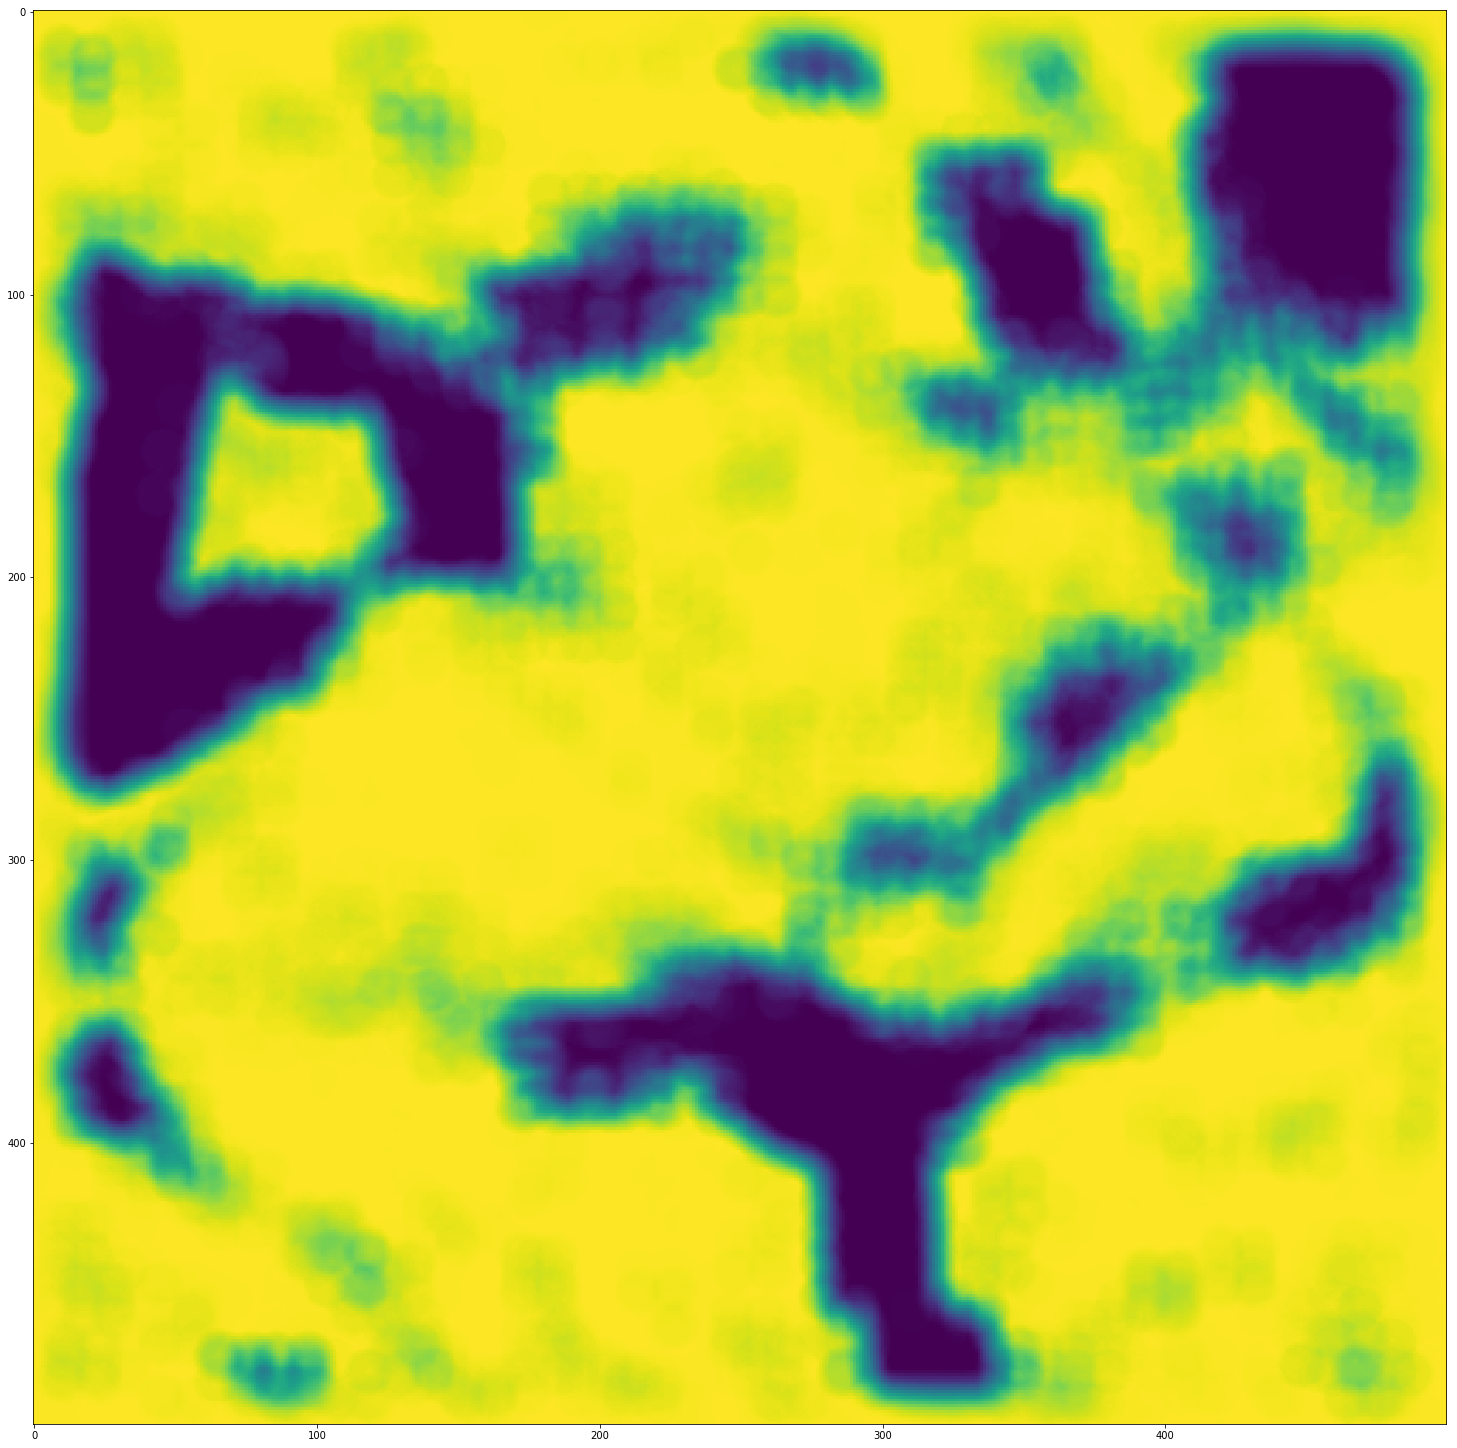

In [42]:
#skyViewArr = np.asarray(Image.open("../cropped_data/500x500/croppedImage_Skyview500x500.tif"))
circ_mask8 = create_circular_mask(8)
newSkyViewArr = OpposingLinearCombination(skyViewArr, 6, 3, 0.8)
newerSkyViewArr = OpposingLinearCombination(newSkyViewArr, 10, 4, 0.001)
plt.figure(num=None, figsize=(28,26), facecolor='w', edgecolor='k')
plt.imshow(gf(newerSkyViewArr, np.nanmean, footprint=circ_mask8))

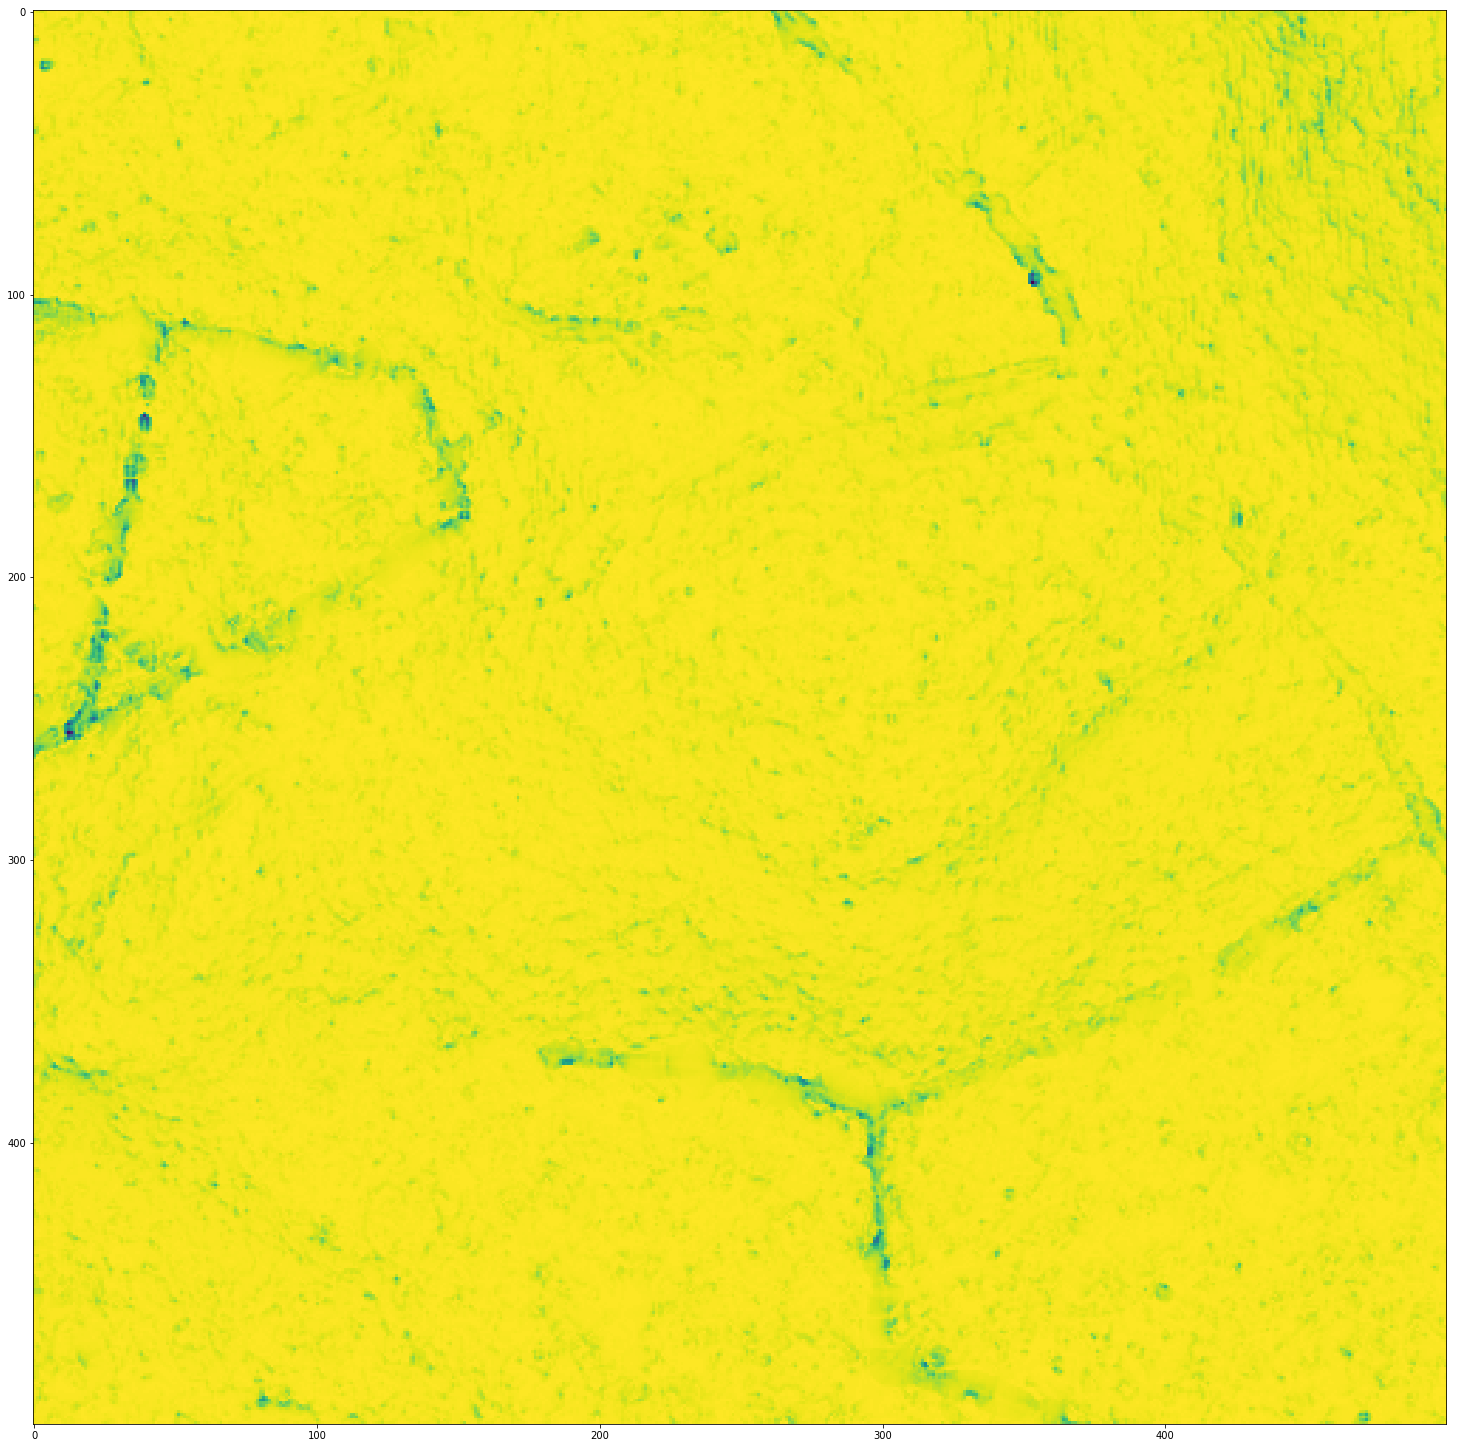

In [18]:
plt.figure(num=None, figsize=(28,26), facecolor='w', edgecolor='k')
plt.imshow(skyViewArr)

In [189]:
import os

for folder in os.listdir("../cropped_data/3_zones"):
    for imageName in os.listdir(f"../cropped_data/3_zones/{folder}"):
        print(imageName)
        np.save(f"{imageName[23:-4]}_raw.npy", np.asarray(Image.open(f"../cropped_data/3_zones/{folder}/{imageName}")))


croppedImage_2625x3000_Ditches_zone1.tif
croppedImage_2625x3000_HPMF_zone1.tif
croppedImage_2625x3000_Impoundment_zone1.tif
croppedImage_2625x3000_Skyview_zone1.tif
croppedImage_2625x3000_Slope_zone1.tif
croppedImage_2625x3000_Ditches_zone2.tif
croppedImage_2625x3000_HPMF_zone2.tif
croppedImage_2625x3000_Impoundment_zone2.tif
croppedImage_2625x3000_Skyview_zone2.tif
croppedImage_2625x3000_Slope_zone2.tif
croppedImage_2625x3000_Ditches_zone3.tif
croppedImage_2625x3000_HPMF_zone3.tif
croppedImage_2625x3000_Impoundment_zone3.tif
croppedImage_2625x3000_Skyview_zone3.tif
croppedImage_2625x3000_Slope_zone3.tif


In [ ]:
#im = Image.open("../cropped_data/croppedImage_skyview130x130.tif")
#im = Image.open("../cropped_data/croppedImage_skyview200x200.tif")
#im = Image.open("../cropped_data/croppedImage_impoundment400x400.tif")
#im = Image.open("../cropped_data/croppedImage_skyview400x400.tif")
#im = Image.open("../cropped_data/croppedImage_skyview2500x2500.tif")
#im = Image.open("../cropped_data/croppedImage_skyview1000x1000.tif")
#skyViewIm = Image.open("../cropped_data/croppedImage_Skyview500x500_10299_10601_10799_11101.tif")
#skyViewArr = np.asarray(skyViewIm)
#slopeIm = Image.open("../cropped_data/croppedImage_Slope500x500.tif")
#slopeArr = np.asarray(slopeIm)
#impoundmentIm = Image.open("../cropped_data/croppedImage_Impoundment500x500.tif")
#impoundmentArr = np.asarray(impoundmentIm)
#HPMFIm = Image.open("../cropped_data/croppedImage_HPMF500x500.tif")
#HPMFArr = np.asarray(HPMFIm)
#ditchesIm = Image.open("../cropped_data/croppedImage_Ditches500x500.tif")
#ditchesArr = np.asarray(ditchesIm)

#skyViewIm = Image.open("../cropped_data/croppedImage_2625x3000_skyview_9950_8302_12575_11302.tif")
#skyViewArr = np.asarray(skyViewIm)
#slopeIm = Image.open("../cropped_data/croppedImage_2625x3000_Slope.tif")
#slopeArr = np.asarray(slopeIm)
#impoundmentIm = Image.open("../cropped_data/croppedImage_2625x3000_Impoundment.tif")
#impoundmentArr = np.asarray(impoundmentIm)
#HPMFIm = Image.open("../cropped_data/croppedImage_2625x3000_HPMF.tif")
#HPMFArr = np.asarray(HPMFIm)
#ditchesIm = Image.open("../cropped_data/croppedImage_2625x3000_Ditches.tif")
#ditchesArr = np.asarray(ditchesIm)

In [160]:
newConicArr = conicMean(skyViewArr, 5, 0.975)

circ_mask3 = create_circular_mask(3)
circ_mask4 = create_circular_mask(4)
circ_mask6 = create_circular_mask(6)
circ_mask15 = create_circular_mask(15)
circ_mask25 = create_circular_mask(25)

meanGreyOpen = morph.grey_opening(gf(newConicArr,np.nanmean,footprint=circ_mask4), footprint=circ_mask4)



np.save("hpmf_feature_means3_zone3.npy", gf(HPMFArr,np.nanmean,footprint=circ_mask3))
np.save("slope_feature_mean3_zone3.npy", gf(slopeArr,np.nanmean,footprint=circ_mask3))
np.save("impoundment_feature_mean3_zone3.npy", gf(impoundmentArr,np.nanmean,footprint=circ_mask3))
np.save("skyview_feature_cone_5_0975_mean4_opening4.npy", meanGreyOpen)
np.save("ditches_zone3.npy", ditchesArr)



575007


'\nhpmf = np.load("hpmf_feature500.npy")\nslope = np.load("slope_feature500.npy")\nimpoundment = np.load("impoundment_feature500.npy")\nskyview = np.load("skyview_feature500.npy")\n\nplt.figure(num=None, figsize=(28,26), facecolor=\'w\', edgecolor=\'k\')\nax = [plt.subplot(3,4,i+1) for i in range(12)]\nfor a in ax:\n    a.set_xticklabels([])\n    a.set_yticklabels([])\n    a.tick_params(bottom=False, left=False)\nplt.subplots_adjust(wspace=0,hspace=0)\n\n\nax[0].title.set_text("Original Slope")\nax[0].imshow(slopeArr)\n\nax[1].title.set_text("Slope mean 6")\nax[1].imshow(slope)\n\nax[2].title.set_text("Original SkyViewFactor")\nax[2].imshow(skyViewArr)\n\nax[3].title.set_text("SkyViewFactor Conic Filter: 5, 0.975,\n mean 4 grey open 4")\nax[3].imshow(skyview)\n\nax[4].title.set_text("Original Impoundment")\nax[4].imshow(impoundmentArr)\n\nax[5].title.set_text("Impoundment mean 3")\nax[5].imshow(impoundment)\n\nax[6].title.set_text("HPMF Original")\nax[6].imshow(HPMFArr)\n\nax[7].title.